In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
random.seed(0)

In [2]:
df = pd.read_csv('SJ001_pv_data_10min.csv') 
df.head()

,SITE_NO,DATE,TIME,GEN_ENERGY,TEMPERATURE,SOLAR_IRRADIANCE,WIND_SPEED,MODULE_TEMPERATURE
0,SJ001,2017-09-01,05:00:00,0.0,,,0.2675,
1,SJ001,2017-09-01,05:10:00,0.0,,,0.0720,
2,SJ001,2017-09-01,05:20:00,0.0,,,0.0000,
3,SJ001,2017-09-01,05:30:00,0.0,,,0.0000,
4,SJ001,2017-09-01,05:40:00,0.0,15.5596,,0.0000,13.8067


In [30]:
# interval = 50
# train_num = 1000
# time_series = np.sin(np.arange(0, 2*train_num/10, 0.1))
# input_series = np.zeros((train_num, interval, 1))
# target_series = np.zeros((train_num, interval, 1))

# for i in range(train_num):
#     input_series[i, :, 0] = time_series[i: i+interval]
#     target_series[i, :, 0] = time_series[i+interval: i+interval*2]
    
# input_series = torch.from_numpy(input_series).to(device)
# target_series = torch.from_numpy(target_series).to(device)

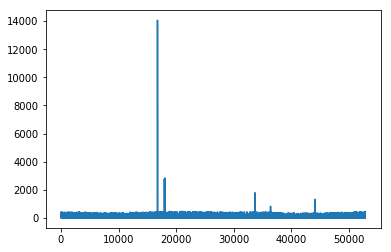

In [3]:
time_series = df['GEN_ENERGY'].values.astype('float')
plt.plot(time_series)
plt.show()

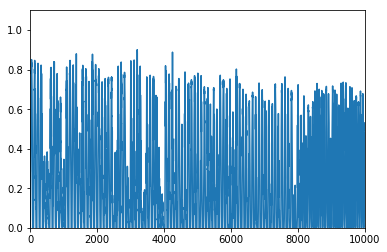

In [70]:
for i in range(len(time_series)):
    if time_series[i] > 500:
        time_series[i] = (time_series[i-1] + time_series[i+1])/2 

time_series = time_series / time_series.max()
plt.plot(time_series)
plt.xlim([0,10000])
plt.ylim([0,1.1])
plt.show()

interval = 97

total_num = 8000
train_num = 7000
test_num = 1000

input_series = np.zeros((train_num + test_num, interval, 1))
target_series = np.zeros((train_num + test_num, interval, 1))

for i in range(train_num + test_num):
    input_series[i, :, 0] = time_series[i: i+interval]
    target_series[i, :, 0] = time_series[i+interval: i+interval*2]

input_series = torch.from_numpy(input_series).to(device)
target_series = torch.from_numpy(target_series).to(device)

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)

    def forward(self, input, hidden):
        batch_size, seq_len = input.shape[0], input.shape[1]
        output = input.float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self, batch_size=1):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first = True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        #print("Decoder input : {} ".format(input))
        batch_size = input.size(0)
        output = input.view(batch_size, 1, 1).float()
        hidden = hidden.float()
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        #print("Decoder output : {} ".format(output))
        
        return output, hidden

#         input = input.view(1, 1, 1).float()
#         outputs = []
#         for i in range(length):
#             output, hidden = self.gru(input, hidden)
#             output = self.out(output)
#             input = output
#             outputs.append(output)
#         outputs = torch.stack(outputs, dim=0)
#         return outputs, hidden
    

In [76]:
hidden_size = 128
encoder1 = EncoderRNN(1, hidden_size).to(device)
decoder1 = DecoderRNN(1, hidden_size, 1).to(device)

# trainIters(encoder1, decoder1, print_every=5000)

In [77]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    
    batch_size = input_tensor.size(0)
    encoder_hidden = encoder.initHidden(batch_size = batch_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(1)
    target_length = target_tensor.size(1)


    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)
    
    decoder_input = input_tensor[:, -1:, :]
    decoder_hidden = encoder_hidden
    outputs = []
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
#     outputs, _ = decoder(decoder_input, decoder_hidden, target_length)

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = target_tensor[:, di:di+1, :] # Teacher forcing
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            outputs.append(decoder_output.squeeze(0))
            decoder_input = decoder_output              
            
    outputs = torch.stack(outputs, dim=1).view(batch_size, target_length, 1)
#     loss += criterion(decoder_output, target_tensor.float())

    loss = criterion(outputs, target_tensor.float())

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [78]:
def trainIters(encoder, decoder, batch_size = 40, epoch = 100, n_iters=train_num, print_every=1000, plot_every=100, learning_rate=0.005):
    plot_losses = []

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    
    for ep in range(epoch):
        loss = 0
        
        for b in range(int(train_num / batch_size)):
            input_tensor = input_series[batch_size*b:batch_size*(b+1)]
            target_tensor = target_series[batch_size*b:batch_size*(b+1)]

            loss += train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        loss = loss/ int(train_num / batch_size)    
        plot_losses.append(loss)
        print("Epoch ", ep, "MSE: ", loss)

In [79]:
trainIters(encoder1, decoder1, epoch=150)

Epoch  0 MSE:  0.0005621180196178856
Epoch  1 MSE:  0.00048590293125316646
Epoch  2 MSE:  0.00046576923165409987
Epoch  3 MSE:  0.00043433600018933895
Epoch  4 MSE:  0.0004524698430351332
Epoch  5 MSE:  0.0004466315586975774
Epoch  6 MSE:  0.00040059064686386156
Epoch  7 MSE:  0.0004805059546525197
Epoch  8 MSE:  0.00037900984934661445
Epoch  9 MSE:  0.00039754712091421445
Epoch  10 MSE:  0.00047551140691179774
Epoch  11 MSE:  0.00042321129558012634
Epoch  12 MSE:  0.00041941047518545646
Epoch  13 MSE:  0.00039179492387948046
Epoch  14 MSE:  0.0005019536562296884
Epoch  15 MSE:  0.015552230422605852
Epoch  16 MSE:  0.01077352029409956
Epoch  17 MSE:  0.006495427275968053
Epoch  18 MSE:  0.004024697320099607
Epoch  19 MSE:  0.0030117062827097656
Epoch  20 MSE:  0.002412560728977987
Epoch  21 MSE:  0.002145626441149016
Epoch  22 MSE:  0.0019915382147098677
Epoch  23 MSE:  0.0019287850504771259
Epoch  24 MSE:  0.0018486179332406598
Epoch  25 MSE:  0.0016779991769299062
Epoch  26 MSE:  0.0

In [22]:
def evaluate(encoder, decoder, input_tensor, target_length):
    with torch.no_grad():
        input_tensor = input_tensor.unsqueeze(0)
        input_length = input_tensor.size()[1]
        encoder_hidden = encoder.initHidden(batch_size = 1)

        encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = input_tensor[:, -1:, :] 
        decoder_hidden = encoder_hidden
        
        decoded = []
        
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            decoded.append(decoder_output.item())
            decoder_input = decoder_output
        return decoded

In [74]:
input_series[570].unsqueeze(0).shape

torch.Size([1, 97, 1])

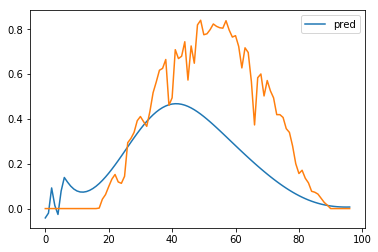

In [87]:
dec = evaluate(encoder1, decoder1, input_series[570], interval)
plt.plot(dec, label = 'pred')
plt.plot(target_series[570].cpu().numpy())
plt.legend()

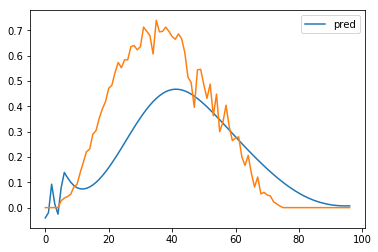

In [88]:
dec = evaluate(encoder1, decoder1, input_series[1630], interval)
plt.plot(dec, label = 'pred')
plt.plot(target_series[1630].cpu().numpy())
plt.legend()

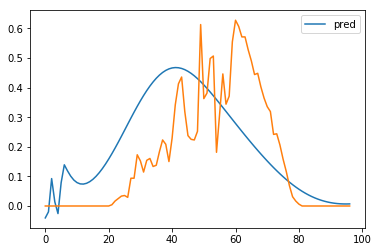

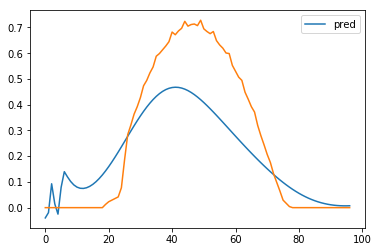

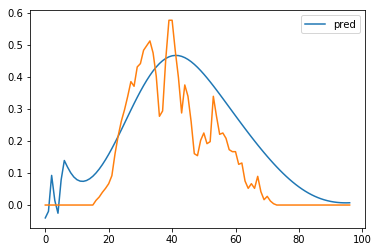

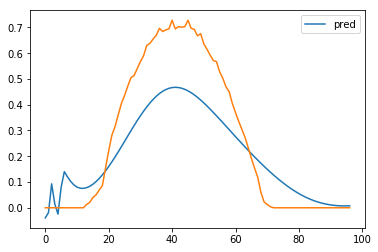

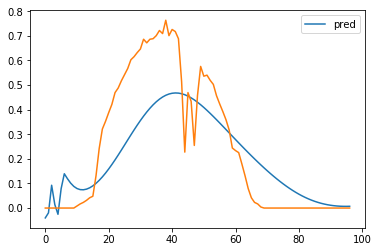

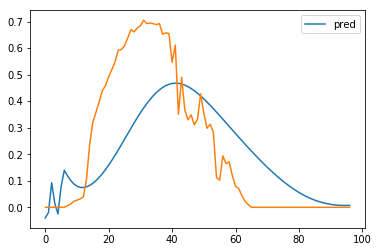

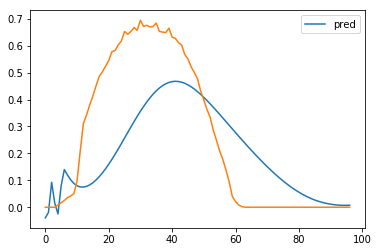

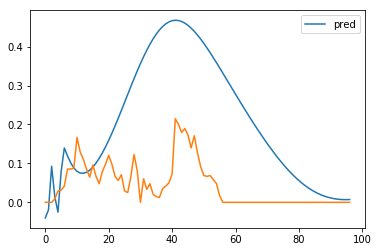

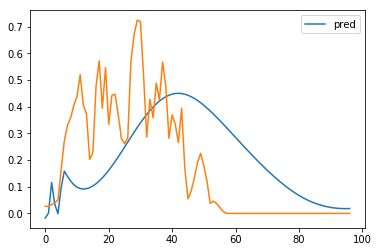

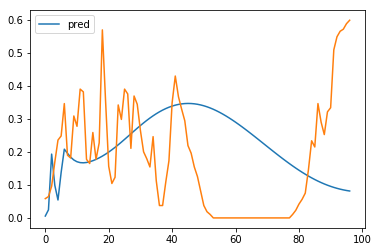

In [89]:
for i in range(10):
    dec = evaluate(encoder1, decoder1, input_series[7080+100*i], interval)
    plt.plot(dec, label = 'pred')
    plt.plot(target_series[7080+100*i].cpu().numpy())
    plt.legend()
    plt.show()

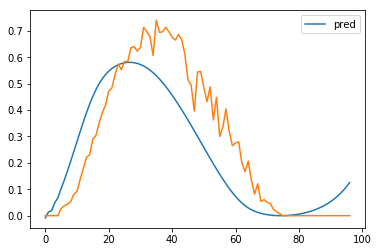

In [66]:
dec = evaluate(encoder1, decoder1, input_series[1630], interval)
plt.plot(dec, label = 'pred')
plt.plot(target_series[1630].cpu().numpy())
plt.legend()

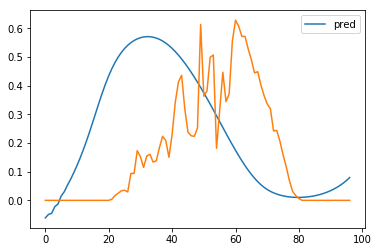

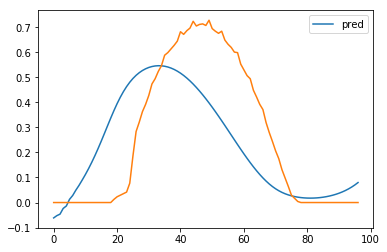

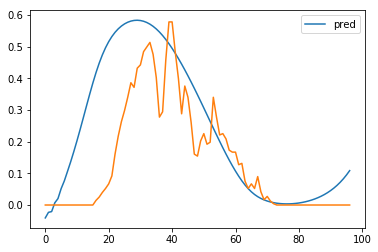

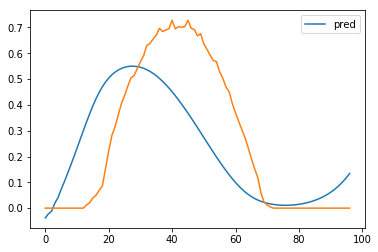

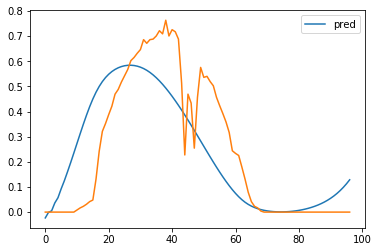

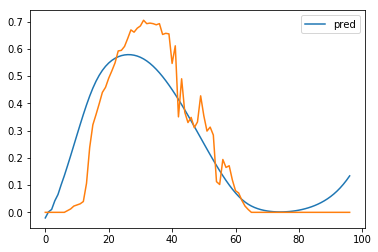

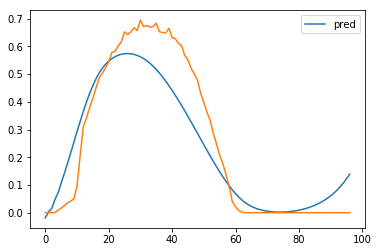

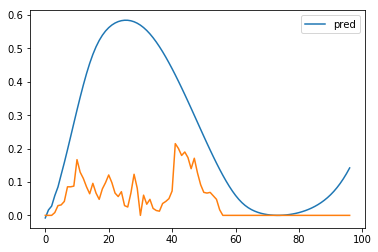

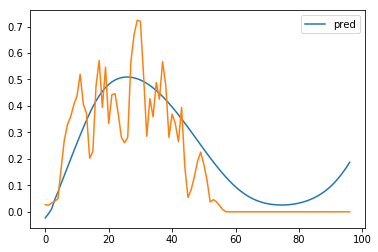

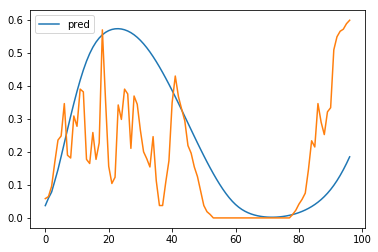

In [75]:
for i in range(10):
    dec = evaluate(encoder1, decoder1, input_series[7080+100*i], interval)
    plt.plot(dec, label = 'pred')
    plt.plot(target_series[7080+100*i].cpu().numpy())
    plt.legend()
    plt.show()